# **Initialization**

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from math import exp, log
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from keras.initializers import glorot_uniform, ones, zeros
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Flatten
from keras.regularizers import l2
import keras.backend as K
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import theano
import theano.tensor as T
!pip install lifelines
from lifelines.utils import concordance_index
!pip install h5py
import h5py
!git clone https://github.com/ThiesCalje/Survival-Analysis-Deep-Learning-AML-.git
import os
os.chdir('/content/Survival-Analysis-Deep-Learning-AML-/Data')

# **Import data**

## AML dataset

In [ ]:
patient_data_processed = pd.read_excel("Data_10_processed.xlsx",index_col="Sample_ID").sort_index()
patient_data = pd.read_excel("Table 10.xlsx",index_col="Sample_ID").sort_index()
gene_expression = pd.read_excel("Data_10_genex.xlsx").T.sort_index().iloc[:-2,:]
patient_data_processed

,"Treatment_Approach_(AML, ALL, Hybrid)",Treatment_Protocol,Treatment_FLT3_Inhibitor,Transcriptional_Identity,Immunophenotype,FAB_Designation,Key_Oncogenic_Driver_Event,FLT3_ITD_Allelic_Ratio,FLT3_ITD_Soft_Clip_Reads,Figure_1B_tSNE.x_coordinate,Figure_1B_tSNE.y_coordinate,LSC6_Score,LSC6_Category,Vital_Status,Survival_Days,Follow_Up_Days,EFS_Days,First_Event,SCT_in_First_Remission
Sample_ID,,,,,,,,,,,,,,,,,,,
SJAML001408_D1,AML,AML02,NO,11q23 rearranged,AML,M5a,KMT2Ar,NaN,NaN,-5.403937,-76.387834,0.204430,low,0,4930,4930,4930.0,Censored,No
SJAML001427_D2,AML,AML02,NO,MK-V,AML,M4,NPM1,NaN,NaN,-21.901230,-56.360340,-1.127061,low,1,118,118,118.0,TRM,No
SJAML001428_D1,AML,AML02,NO,MK-V,AML,M4,Other,NaN,NaN,-26.705930,-53.003653,-1.377134,low,0,4543,4543,4543.0,Censored,No
SJAML001430_D2,AML,AML02,NO,MK-V,AML,M4,NPM1,NaN,NaN,-26.821585,-61.888154,-0.050137,low,0,4840,4840,1106.0,Relapse,No
SJAML001444_D1,AML,AML02,NO,MK-V,AML,M4,KMT2Ar,NaN,NaN,-32.526113,-77.818769,1.732514,medium,1,536,536,348.0,Relapse,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SJMPAL046468_D1,AML,NaN,NaN,MPAL-B/M,MPAL B/M,NaN,Other,NaN,NaN,32.705022,-16.550122,-0.873553,low,0,1168,1168,NaN,NaN,NaN
SJMPAL046469_D1,ALL,NaN,NaN,MPAL-B/M,AUL,NaN,Ph/Ph Like,NaN,NaN,19.830534,-5.378619,0.554643,low,0,978,978,NaN,NaN,NaN
SJMPAL046470_D1,ALL,NaN,NaN,MPAL-B/M,MPAL B/M,NaN,Other,NaN,NaN,26.595548,-15.147478,0.720019,low,0,615,615,NaN,NaN,NaN


## Gaussian dataset (DeepSURV)

In [ ]:
h5_file = 'https://github.com/ThiesCalje/Survival-Analysis-Deep-Learning-AML-/blob/main/Data/gaussian_survival_data_1.h5?raw=true'

In [ ]:
def normalize(X):
  X = (X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
  return X

In [ ]:
with h5py.File("gaussian_survival_data_1.h5", 'r') as f:
    X = f["train"]['x'][()]
    e = f["train"]['e'][()].reshape(-1, 1)
    y = f["train"]['t'][()].reshape(-1, 1)

x_train_gauss = pd.DataFrame(normalize(X))
y_train_gauss = pd.DataFrame(normalize(y))
E_train_gauss = pd.DataFrame(normalize(e))

with h5py.File("gaussian_survival_data_1.h5", 'r') as f:
    X = f["test"]['x'][()]
    e = f["test"]['e'][()].reshape(-1, 1)
    y = f["test"]['t'][()].reshape(-1, 1)

x_test_gauss = pd.DataFrame(normalize(X))
y_test_gauss = pd.DataFrame(normalize(y))
E_test_gauss = pd.DataFrame(normalize(e))


## Simulated dataset

### Initiate data generator

In [ ]:
class SimulatedData:
    def __init__(self, hr_ratio,
        average_death = 570,
        censor_mode = 'end_time', end_time = 15, observed_p = None,
        num_features = 10, num_var = 2,
        treatment_group = False):
        """
        Factory class for producing simulated survival data.
        Current supports two forms of simulated data:
            Linear:
                Where risk is a linear combination of an observation's features
            Nonlinear (Gaussian):
                A gaussian combination of covariates
        Parameters:
            hr_ratio: lambda_max hazard ratio.
            average_death: average death time that is the mean of the
                Exponentional distribution.
            censor_mode: the method to calculate whether a patient is censored.
                Options: ['end_time', 'observed_p']
                'end_time': requires the parameter end_time, which is used to censor any patient with death_time > end_time
                'observed_p': requires the parammeter observed_p, which is the percentage of patients with observed death times
            end_time: censoring time that represents an 'end of study'. Any death
                time greater than end_time will be censored.
            num_features: size of observation vector. Default: 10.
            num_var: number of varaibles simulated data depends on. Default: 2.
            treatment_group: True or False. Include an additional covariate
                representing a binary treatment group.
        """

        self.hr_ratio = hr_ratio
        self.censor_mode = censor_mode
        self.end_time = end_time
        self.observed_p = observed_p
        self.average_death = average_death
        self.treatment_group = treatment_group
        self.m = int(num_features) + int(treatment_group)
        self.num_var = num_var

    def _linear_H(self,x):
        """
        Calculates a linear combination of x's features.
        Coefficients are 1, 2, ..., self.num_var, 0,..0]
        Parameters:
            x: (n,m) numpy array of observations
        Returns:
            risk: the calculated linear risk for a set of data x
        """
        # Make the coefficients [1,2,...,num_var,0,..0]
        b = np.zeros((self.m,))
        b[0:self.num_var] = range(1,self.num_var + 1)

        # Linear Combinations of Coefficients and Covariates
        risk = np.dot(x, b)
        return risk

    def _gaussian_H(self,x,
        c= 0, rad= 60):
        """
        Calculates the Gaussian function of a subset of x's features.
        Parameters:
            x: (n, m) numpy array of observations.
            c: offset of Gaussian function. Default: 0.0.
            r: Gaussian scale parameter. Default: 0.5.
        Returns:
            risk: the calculated Gaussian risk for a set of data x
        """
        max_hr, min_hr = log(self.hr_ratio), log(1.0 / self.hr_ratio)

        # Z = ( (x_0 - c)^2 + (x_1 - c)^2 + ... + (x_{num_var} - c)^2)
        z = np.square((x - c))
        z = np.sum(z[:,0:self.num_var], axis = -1)

        # Compute Gaussian
        risk = max_hr * (np.exp(-(z) / (2 * rad ** 2)))
        return risk

    def generate_data(self, N,
        method = 'gaussian', gaussian_config = {},
        **kwargs):
        """
        Generates a set of observations according to an exponentional Cox model.
        Parameters:
            N: the number of observations.
            method: the type of simulated data. 'linear' or 'gaussian'.
            guassian_config: dictionary of additional parameters for gaussian
                simulation.
        Returns:
            dataset: a dictionary object with the following keys:
                'x' : (N,m) numpy array of observations.
                't' : (N) numpy array of observed time events.
                'e' : (N) numpy array of observed time intervals.
                'hr': (N) numpy array of observed true risk.
        See:
        Peter C Austin. Generating survival times to simulate cox proportional
        hazards models with time-varying covariates. Statistics in medicine,
        31(29):3946-3958, 2012.
        """

        # Patient Baseline information
        data = np.random.uniform(low= -1, high= 1,
            size = (N,self.m))
        self.data = data
        if self.treatment_group:
            data[:,-1] = np.squeeze(np.random.randint(0,2,(N,1)))
            print(data[:,-1])

        # Each patient has a uniform death probability
        p_death = self.average_death * np.ones((N,1))

        # Patients Hazard Model
        # \lambda(t|X) = \lambda_0(t) exp(H(x))
        #
        # risk = True log hazard ratio
        # log(\lambda(t|X) / \lambda_0(t)) = H(x)
        if method == 'linear':
            risk = self._linear_H(data)

        elif method == 'gaussian':
            risk = self._gaussian_H(data,**gaussian_config)

        # Center the hazard ratio so population dies at the same rate
        # independent of control group (makes the problem easier)
        risk = risk - np.mean(risk)

        # Generate time of death for each patient
        # currently exponential random variable
        death_time = np.zeros((N,1))
        for i in range(N):
            if self.treatment_group and data[i,-1] == 0:
                death_time[i] = np.random.exponential(p_death[i])
            else:
                death_time[i] = np.random.exponential(p_death[i]) / exp(risk[i])
        death_time = death_time/max(death_time)*6000
        # If Censor_mode is 'observed_p': then find the end time in which observed_p percent of patients have an observed death
        if self.censor_mode is 'observed_p':
            if self.observed_p is None:
                raise ValueError("Parameter observed_p must be porivded if censor_mode is configured to 'observed_p'")
            end_time_idx = int(N * self.observed_p)
            self.end_time = np.sort(death_time.flatten())[end_time_idx]

        # Censor anything that is past end time
        censoring = np.ones((N,1))
        #death_time[death_time > self.end_time] = self.end_time
        censoring[death_time == self.end_time] = 0

        # Flatten Arrays to Vectors
        death_time = np.squeeze(death_time)
        censoring = np.squeeze(censoring)

        dataset = {
            'x' : data.astype(np.float32),
            'E' : censoring.astype(np.int32),
            'T' : death_time.astype(np.float32),
            'hr' : risk.astype(np.float32)
        }

        return dataset

### Data generator

In [ ]:
def generate_data(method, treatment_group = False):
    np.random.seed(123)
    sd = SimulatedData(5, num_features=9)
    train_data = sd.generate_data(400, method)
    valid_data = sd.generate_data(2000, method)
    test_data  = sd.generate_data(2000, method)
    return train_data, valid_data, test_data

# **Processing functions**

In [ ]:
def data_filter(data, keep_variables, gene_expression, patient_data, d, one_hot = False):

    T = data['Survival_Days']
    E = data['Vital_Status']

    data_split = {'categorical':["Sample_ID",
                             "Treatment_Approach_(AML, ALL, Hybrid)",
                             "Treatment_Protocol",
                             "Treatment_FLT3_Inhibitor",
                             "Transcriptional_Identity",
                             "Immunophenotype",
                             "FAB_Designation",
                             "Key_Oncogenic_Driver_Event",
                             "LSC6_Category",
                             "First_Event",
                             "SCT_in_First_Remission"],
                 'numerical':["FLT3_ITD_Allelic_Ratio",
                           "FLT3_ITD_Soft_Clip_Reads",
                           "Figure_1B_tSNE.x_coordinate",
                           "Figure_1B_tSNE.y_coordinate",
                           "LSC6_Score",
                           "Vital_Status",
                           "Survival_Days",
                           "Follow_Up_Days",
                           "EFS_Days"],
                'keep_c':[],
                'keep_n':[]
              }

    for variable in keep_variables:

        if variable in data_split['categorical']:
            data_split['keep_c'].append(variable)
            data_split['categorical'].pop(data_split['categorical'].index(variable))

        else:
            data_split['keep_n'].append(variable)
            data_split['numerical'].pop(data_split['numerical'].index(variable))

    data_c = data[data_split['keep_c']]
    data_c = get_TSNE_embedding(data_c, d, gene_expression, patient_data)
    
    data_n = data[data_split['keep_n']]
    if one_hot == True:
        data_c = pd.get_dummies(data_c,dummy_na=True)

    data = data_c.join(data_n)
    data.index = list(E.index)

    return data_c, data_n, data, E, T

In [ ]:
def split_data(data, E, T, split = 0.75):

    censored = data[E == 0]

    num_patients = len(censored)
    ind_shuffle = random.sample(list(range(num_patients)), num_patients)
    train_size = int(split*num_patients) 
    censored_train = censored.iloc[ind_shuffle][:train_size]
    censored_test = censored.iloc[ind_shuffle][train_size:]

    uncensored = data[E == 1]

    num_patients = len(uncensored)
    ind_shuffle = random.sample(list(range(num_patients)), num_patients )
    train_size = int(split*num_patients) 
    uncensored_train = uncensored.iloc[ind_shuffle][:train_size]
    uncensored_test = uncensored.iloc[ind_shuffle][train_size:]

    x_train = pd.concat([censored_train, uncensored_train])
    E_train = E.loc[list(x_train.index)]
    T_train = T.loc[list(x_train.index)]
    x_test = pd.concat([censored_test, uncensored_test])
    E_test = E.loc[list(x_test.index)]
    T_test = T.loc[list(x_test.index)]

    data_train = {"x": x_train,
                  "E": E_train,
                  "T": T_train}
    data_test =  {"x": x_test,
                  "E": E_test,
                  "T": T_test}

    return data_train, data_test

In [ ]:
def get_TSNE_embedding(data_c, d, gene_expression, patient_data):

    embedded_data = pd.DataFrame(np.zeros(len(data_c)), columns=['placeholder'])
    embedded_data.index = list(data_c.index)

    for category in data_c:

        category_data = data_c[category].to_frame()
        embedded_patients = pd.DataFrame()
        cluster, embedding = embedding_TSNE(gene_expression, patient_data, category, d)

        for sample in category_data.index:

            patient_cat = category_data.loc[sample]
            mapping = pd.DataFrame(embedding.loc[patient_cat])
            embedded_patients = pd.concat([embedded_patients,mapping]).astype('float')

        embedded_patients.index = list(category_data.index)
        patient_data_processed2 = category_data.join(embedded_patients)
        del patient_data_processed2[category]
        embedded_data = embedded_data.join(patient_data_processed2)
        
    del embedded_data['placeholder']

    return embedded_data

In [ ]:
def embedding_TSNE(gene_expression, patient_data, var_of_interest, n, p = 1, weighted = True):

    tsne = TSNE(n, perplexity = 20, verbose=1, random_state = 69)
    tsne_coordinates = tsne.fit_transform(gene_expression)

    patient_categories = patient_data[var_of_interest]
    categories = np.unique(patient_categories)
    clusters = {entity:tsne_coordinates[patient_categories == entity] for entity in categories}

    dimension = len(clusters[list(clusters.keys())[0]][0,:])
    embedding = []
 
    num_colors = len(np.unique(patient_categories))
    colors = plt.get_cmap('rainbow', num_colors)
    
    fig = plt.figure(figsize=(14,10))

    for entity in enumerate(clusters):

        i = entity[0]
        entity = entity[1]

        coords = clusters[entity]
        n_entities = len(coords)
        d = distance_matrix(coords,coords)**p
        

        if weighted == True:
            weights = 1/np.array([np.sum(d[i]) for i in range(n_entities)])
        else:
            weights = np.ones(n_entities)

        com = [sum(coords[:,i]*weights)/sum(weights) for i in range(dimension)]
        embedding.append(com)
        clusters[entity] = clusters[entity], weights, com

        if dimension == 2:
            plt.scatter(coords[:,0],coords[:,1],label=entity,color=colors(i))
            plt.scatter(com[0], com[1], s = 250, color = colors(i), marker = 'X', edgecolors="black")
    
    coordinates = ["X_{}".format(var_of_interest),"Y_{}".format(var_of_interest),"Z_{}".format(var_of_interest)]
    names = []
    for d in range(dimension):
        names.append(coordinates[d])

    embedding = pd.DataFrame(embedding, index=categories, columns = names)
    plt.legend()
    plt.xlabel('tSNE-one')
    plt.ylabel('tSNE-two')

    return clusters, embedding

# **Auto-encoding** (broken)

In [ ]:
def Autoencoder_em(data,em_dim,include_na):

  labels = pd.get_dummies(data,dummy_na=include_na)
  m = len(set(data))
  encoder = Sequential()

  encoder.add(Embedding(input_dim= m, output_dim= em_dim, input_length= m, embeddings_initializer=ones()))
  dif = abs(encoder.get_weights()[0])
  encoder.add(Flatten())
  encoder.add(Dense(m,kernel_initializer=glorot_uniform()))

  encoder.compile(loss= "categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(0.1))

  
  #encoder.summary()

  history = encoder.fit(labels, labels, epochs=100, shuffle=False, verbose=False,validation_split=0.2)
  dif = abs(dif - abs(encoder.get_weights()[0]))
  plot_history(history,0.2)
  pred = encoder.predict(labels)
  embeddings = encoder.get_weights()[0]

  return pred[0]/max(pred[0]), dif

pred, dif = Autoencoder_em(data_c,6, False)
print('prediction = ', '\n', pred)
print('difference = ', '\n', dif)

ValueError: ignored

In [ ]:
def Autoencoder_(data,em_dim,include_na):

  labels = pd.get_dummies(data,dummy_na=include_na)
  m = len(set(data))
  encoder = Sequential()

  encoder.add(Embedding(input_dim= m, output_dim= em_dim, input_length= m, embeddings_initializer=ones()))
  encoder.add(Flatten())
  encoder.add(Dense(m,kernel_initializer=glorot_uniform()))

  encoder.compile(loss= "categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(0.1))

  
  #encoder.summary()

  history = encoder.fit(labels, labels, epochs=300, shuffle=False, verbose=False,validation_split=0.2)
  plot_history(history,0.2)
  pred = encoder.predict(labels)
  embeddings = encoder.get_weights()[0]

  return embeddings, pred[0]/max(abs(pred[0]))

print(Autoencoder(data_c["Key_Oncogenic_Driver_Event"],5, True))

# **Model**

In [ ]:
def build_and_compile_model(E, T, hid_lay, dropout_rate, input,activation, L2, learning_rate, momemtum, embedding=False):

  model = Sequential()

  if embedding == True:
    print("do something")


  model.add(Dense(hid_lay[0], input_shape=(input,),
                kernel_initializer=glorot_uniform(),
                kernel_regularizer=l2(L2))) # shape= length, dimension
  model.add(Activation(activation))
  model.add(Dropout(dropout_rate))

  if len(hid_lay) != 1:
    for n in hid_lay[1:]:
        model.add(Dense(n,kernel_initializer=glorot_uniform(),
                        kernel_regularizer=l2(L2))) # shape= length, dimension
        model.add(Activation(activation))
        model.add(Dropout(dropout_rate))


  model.add(Dense(1, activation="linear",
                    kernel_initializer=glorot_uniform(),
                    kernel_regularizer=l2(L2),
                    activity_regularizer=l2(0.01)))

  model.compile(loss=neg_log_likelihood(E,T),
                optimizer=tf.keras.optimizers.Adam(learning_rate
                                                  )
  )
  return model

In [ ]:
def neg_log_likelihood(E,T):
    def loss(y_true, y_pred):
        mask = np.ones((len(T), len(T)))
        mask[(y.T - y) > 0] = 0
        hazard_ratio = K.exp(y_pred)*mask
        log_risk = K.log(K.cumsum(hazard_ratio, axis=1)) / np.sum(mask,axis=0)
        uncensored_likelihood = y_pred - log_risk
        censored_likelihood = uncensored_likelihood * E
        neg_likelihood = -K.sum(censored_likelihood)/sum(E)
        return neg_likelihood
    return loss

# **Experiments**

## Function set-up

In [ ]:
def model_experiment(data_train, data_test, n, hidden_layers, dropout_rate, activation, L2, learning_rate, momentum ,labels = None, plot = False):
  
    x_train = data_train["x"]
    E_train = data_train["E"]
    T_train = data_train["T"]

    x_test = data_test["x"]
    E_test = data_test["E"]
    T_test = data_test["T"]
    c = []

    fig1 = plt.figure(figsize=(10,10))
    input = x_train.shape[1]

    for i in range(n):
        
        model = build_and_compile_model(E_train,
                                        T_train,
                                        hidden_layers, 
                                        dropout_rate, 
                                        input, 
                                        activation, 
                                        L2, 
                                        learning_rate, 
                                        momentum)
        model.build()
    #model.summary()

        history = model.fit(x_train, 
                            labels, 
                            epochs=100, 
                            shuffle=False, 
                            verbose=False,
                            validation_split=0)  # Shuffle False --> Important!!
        if plot == True:
            plot_history(history)
        h_est = model.predict(x_test)
        ci = concordance_index(T_test,-h_est , E_test)
        c.append(ci)
        print("Training network", i+1, "/",n, "The c-index = ", ci)

    fig2 = plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.hist(c, bins = int(n/2))
    plt.subplot(1,2,2)
    plt.boxplot(c)

    return print(np.mean(c))


In [ ]:
def plot_history(history, validation_split=0):

  plt.plot(history.history['loss'],label='Training loss')

  if validation_split != 0:
    plt.plot(history.history['val_loss'], label='Validation loss')
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  #plt.legend()
  
  return 'plot'

## Experiments

### Data (AML)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 435 samples in 0.011s...
[t-SNE] Computed neighbors for 435 samples in 0.158s...
[t-SNE] Computed conditional probabilities for sample 435 / 435
[t-SNE] Mean sigma: 18.417190
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.130768
[t-SNE] KL divergence after 1000 iterations: 0.585087


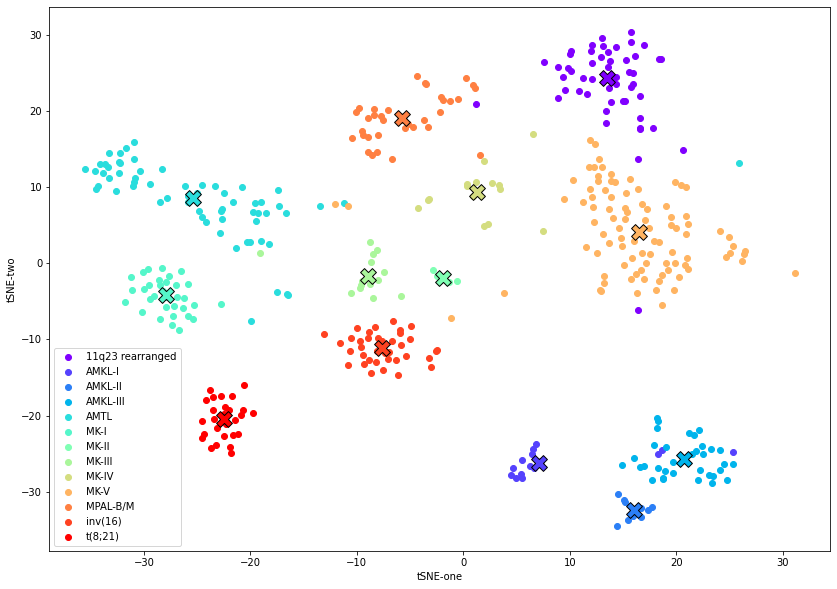

In [ ]:
keep_variables = ["Transcriptional_Identity", "LSC6_Score"]
data_c, data_n, data, E, T = data_filter(patient_data_processed, keep_variables, gene_expression, patient_data, 2)
index = list(data.index)
columns = list(data.columns)
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data),index=index,columns=columns)
data_train, data_test = split_data(data, E, T, split = 0.75)


### Data (Gaussian)

### Training & evaluating the network

Training network 1 / 100
Training network 2 / 100
Training network 3 / 100
Training network 4 / 100
Training network 5 / 100
Training network 6 / 100
Training network 7 / 100
Training network 8 / 100
Training network 9 / 100
Training network 10 / 100
Training network 11 / 100
Training network 12 / 100
Training network 13 / 100
Training network 14 / 100
Training network 15 / 100
Training network 16 / 100
Training network 17 / 100
Training network 18 / 100
Training network 19 / 100
Training network 20 / 100
Training network 21 / 100
Training network 22 / 100
Training network 23 / 100
Training network 24 / 100
Training network 25 / 100
Training network 26 / 100
Training network 27 / 100
Training network 28 / 100
Training network 29 / 100
Training network 30 / 100
Training network 31 / 100
Training network 32 / 100
Training network 33 / 100
Training network 34 / 100
Training network 35 / 100
Training network 36 / 100
Training network 37 / 100
Training network 38 / 100
Training network 39 /

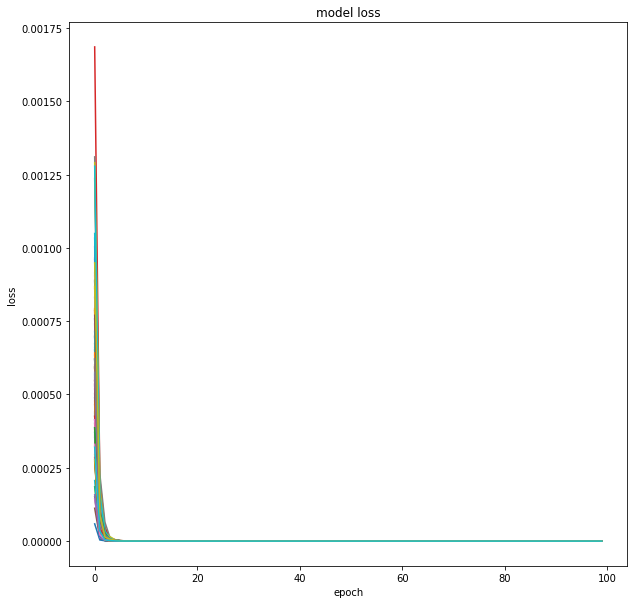

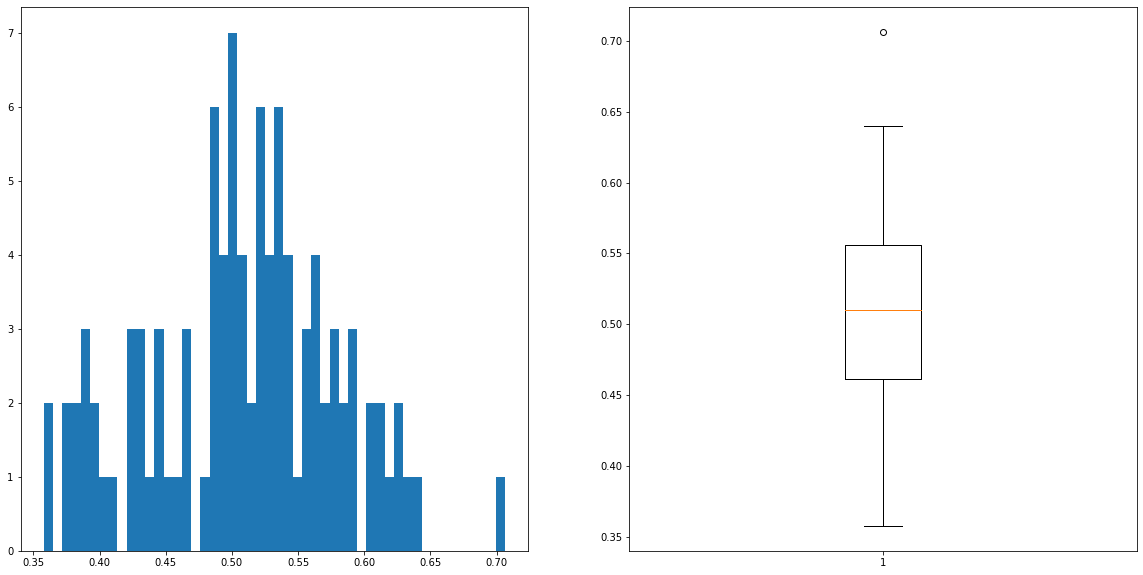

In [ ]:
n = 100
hidden_layers = [44]
dropout_rate = 0.160
activation = "relu"
L2 = 0
learning_rate = 0.047
momentum = 0.859
model_experiment(data_train, data_test, n, hidden_layers, dropout_rate, activation, L2, learning_rate, momentum ,labels = None, plot = True) 